# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Рассчитаем параметры теста, оценим корректность его проведения и проанализируем результаты эксперимента.

### 1. Работа с историческими данными (EDA)

####  Загрузка исторических данных
На первом этапе поработаем с историческими данными приложения:

In [1]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sessions_history = pd.read_csv("/datasets/sessions_project_history.csv")
display(sessions_history.info())
display(sessions_history.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


None

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


####  Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Выведем на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберем любого из них.

- Изучим таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [3]:
user_sessions_count = (
    sessions_history.groupby("user_id")["session_id"]
    .nunique()
    .reset_index(name="unique_sessions")
)

max_sessions_user = user_sessions_count.sort_values(
    "unique_sessions", ascending=False
).iloc[0]["user_id"]

user_data = sessions_history[sessions_history["user_id"] == max_sessions_user]

user_data = user_data.drop_duplicates(subset="session_id")

print(f"Пользователь с наибольшим количеством сессий: {max_sessions_user}")
display(user_data)

Пользователь с наибольшим количеством сессий: 10E0DEFC1ABDBBE0


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


####  Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используем исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

- Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считаем, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Построем линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразим их на одном графике.

- Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

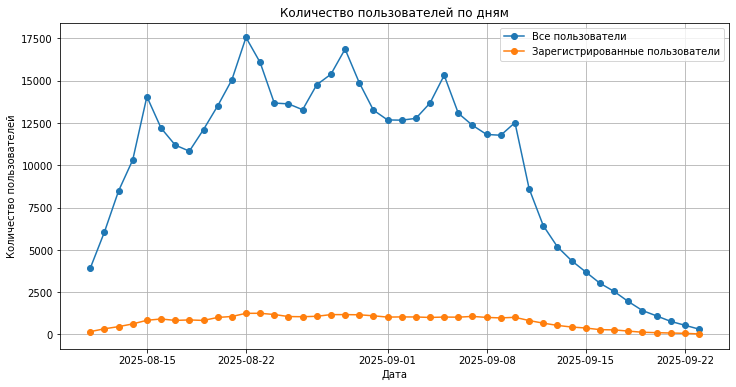

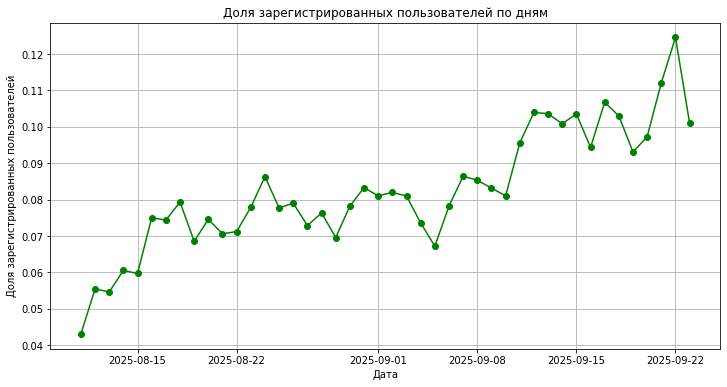

In [4]:
sessions_history["session_date"] = pd.to_datetime(sessions_history["session_date"])

daily_stats = (
    sessions_history.groupby("session_date")
    .agg(
        total_users=("user_id", "nunique"),
        registered_users=("registration_flag", "sum")
    )
    .reset_index()
)

daily_stats["registered_share"] = (
    daily_stats["registered_users"] / daily_stats["total_users"]
)

plt.figure(figsize=(12, 6))
plt.plot(daily_stats["session_date"], daily_stats["total_users"], label="Все пользователи", marker="o")
plt.plot(daily_stats["session_date"], daily_stats["registered_users"], label="Зарегистрированные пользователи", marker="o")
plt.title("Количество пользователей по дням")
plt.xlabel("Дата")
plt.ylabel("Количество пользователей")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(daily_stats["session_date"], daily_stats["registered_share"], color="green", marker="o")
plt.title("Доля зарегистрированных пользователей по дням")
plt.xlabel("Дата")
plt.ylabel("Доля зарегистрированных пользователей")
plt.grid(True)
plt.show()


####  Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдем количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29 160 сессиях, две страницы — в 105 536 сессиях и так далее.

- Построем столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

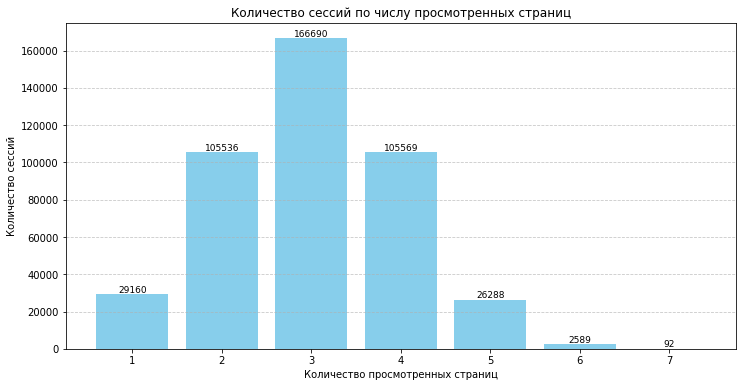

In [5]:
page_views_counts = (
    sessions_history.groupby("page_counter")["session_id"]
    .count()
    .reset_index(name="sessions_count")
)

plt.figure(figsize=(12, 6))
bars = plt.bar(page_views_counts["page_counter"], page_views_counts["sessions_count"], color="skyblue")

plt.title("Количество сессий по числу просмотренных страниц")
plt.xlabel("Количество просмотренных страниц")
plt.ylabel("Количество сессий")
plt.grid(axis="y", linestyle="--", alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, str(height), ha='center', va='bottom', fontsize=9)

plt.show()


#### Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Построим график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

Среднее за весь период: 0.3075
Среднее за последние 7 дней: 0.3030
Стандартное отклонение за последние 7 дней: 0.0132


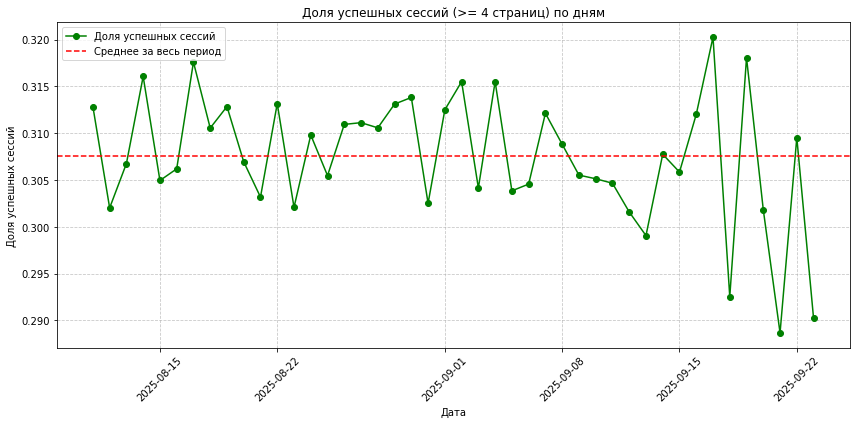

In [6]:
import numpy as np
sessions_history["good_session"] = np.where(sessions_history["page_counter"] >= 4, 1, 0)

good_sessions_daily = (
    sessions_history.groupby("session_date")["good_session"]
    .mean()
    .reset_index()
)

mean_all = good_sessions_daily["good_session"].mean()
mean_last_7days = good_sessions_daily.tail(7)["good_session"].mean()
std_dev_last_7days = good_sessions_daily.tail(7)["good_session"].std()

print(f"Среднее за весь период: {mean_all:.4f}")
print(f"Среднее за последние 7 дней: {mean_last_7days:.4f}")
print(f"Стандартное отклонение за последние 7 дней: {std_dev_last_7days:.4f}")
plt.figure(figsize=(12, 6))
plt.plot(good_sessions_daily["session_date"], good_sessions_daily["good_session"], 
         marker="o", color="green", label="Доля успешных сессий")
plt.axhline(mean_all, color='red', linestyle='--', label="Среднее за весь период")
plt.title("Доля успешных сессий (>= 4 страниц) по дням")
plt.xlabel("Дата")
plt.ylabel("Доля успешных сессий")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


###  Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

####  Формулировка нулевой и альтернативной гипотез

Основная метрика - просмотр более 4 страниц за 1 сессию, т.е. кол-во успешных сессий.
Нулевая гипотеза - новый алгоритм не увеличивает количество успешных сессий
Альтернативная гипотеза новый алгоритм увеличивает количество успешных сессий

####  Расчёт размера выборки

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки используем метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.


In [7]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Задаём параметры
alpha = 0.05   # Уровень значимости
beta = 0.2     # Ошибка второго рода
power = 0.8    # Мощность теста
p1 = 0.3       # Базовый уровень доли
mde = 0.03 * p1  # Минимальный детектируемый эффект (в абсолютном значении)

# Рассчитываем effect size
effect_size = proportion_effectsize(p1, p1 + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size=effect_size,
    power=power,
    alpha=alpha,
    ratio=1  # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")


Необходимый размер выборки для каждой группы: 41040


####  Расчёт длительности A/B-теста

Используем данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитаем среднее количество уникальных пользователей приложения в день.

- Определим длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения.

In [8]:
from math import ceil

avg_daily_users = daily_stats["total_users"].mean()

total_sample_size = sample_size * 2

test_duration = ceil(total_sample_size / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровне трафика в {avg_daily_users:.0f} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровне трафика в 9907 пользователей в день составит 9 дней


###  Мониторинг А/В-теста

####  Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считаем и сохраняем в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем и выведите на экран процентную разницу в количестве пользователей в группах A и B. Построим любую удобную визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

Уникальных пользователей в группе A: 1477
Уникальных пользователей в группе B: 1466
Процентная разница: 0.74%


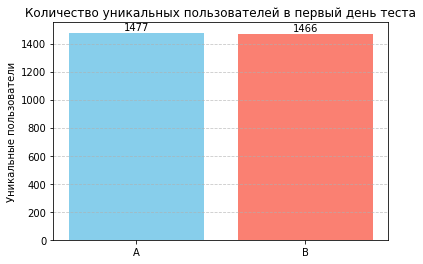

In [9]:
sessions_test_part = pd.read_csv("/datasets/sessions_project_test_part.csv")
sessions_test_part["session_date"] = pd.to_datetime(sessions_test_part["session_date"])

first_day = sessions_test_part["session_date"].min()
day_one_data = sessions_test_part[sessions_test_part["session_date"] == first_day]

users_per_group = (
    day_one_data.groupby("test_group")["user_id"]
    .nunique()
    .reset_index(name="unique_users")
)

A_users = users_per_group.loc[users_per_group["test_group"] == "A", "unique_users"].iloc[0]
B_users = users_per_group.loc[users_per_group["test_group"] == "B", "unique_users"].iloc[0]
P = 100 * abs(A_users - B_users) / A_users

print(f"Уникальных пользователей в группе A: {A_users}")
print(f"Уникальных пользователей в группе B: {B_users}")
print(f"Процентная разница: {P:.2f}%")

plt.figure(figsize=(6, 4))
bars = plt.bar(users_per_group["test_group"], users_per_group["unique_users"], color=["skyblue", "salmon"])
plt.title("Количество уникальных пользователей в первый день теста")
plt.ylabel("Уникальные пользователи")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, str(height), ha='center', va='bottom')

plt.show()

####  Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B, или убедимся, что таких нет.

In [10]:
users_A = set(sessions_test_part.loc[sessions_test_part["test_group"] == "A", "user_id"].unique())
users_B = set(sessions_test_part.loc[sessions_test_part["test_group"] == "B", "user_id"].unique())

overlap_users = users_A.intersection(users_B)

print(f"Количество пользователей, попавших в обе группы: {len(overlap_users)}")
if len(overlap_users) > 0:
    print("ID этих пользователей:", overlap_users)
else:
    print("Пересечения нет, группы независимы.")

Количество пользователей, попавших в обе группы: 0
Пересечения нет, группы независимы.


####  Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

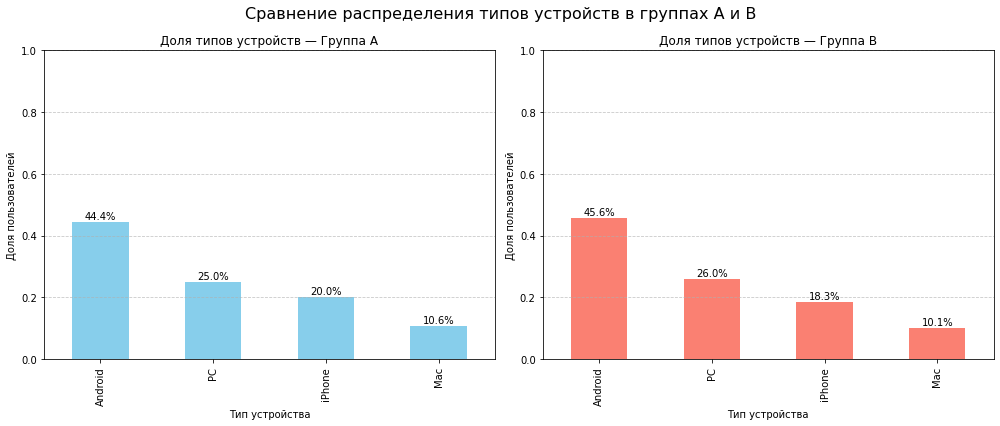

In [11]:
group_A = sessions_test_part[sessions_test_part["test_group"] == "A"]
group_B = sessions_test_part[sessions_test_part["test_group"] == "B"]

device_dist_A = group_A.groupby("device")["user_id"].nunique().sort_values(ascending=False)
device_dist_B = group_B.groupby("device")["user_id"].nunique().sort_values(ascending=False)

device_share_A = device_dist_A / device_dist_A.sum()
device_share_B = device_dist_B / device_dist_B.sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

device_share_A.plot(kind="bar", ax=axes[0], color="skyblue")
axes[0].set_title("Доля типов устройств — Группа A")
axes[0].set_ylabel("Доля пользователей")
axes[0].set_xlabel("Тип устройства")
axes[0].set_ylim(0, 1)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)
for i, v in enumerate(device_share_A):
    axes[0].text(i, v + 0.01, f"{v:.1%}", ha="center")

device_share_B.plot(kind="bar", ax=axes[1], color="salmon")
axes[1].set_title("Доля типов устройств — Группа B")
axes[1].set_ylabel("Доля пользователей")
axes[1].set_xlabel("Тип устройства")
axes[1].set_ylim(0, 1)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)
for i, v in enumerate(device_share_B):
    axes[1].text(i, v + 0.01, f"{v:.1%}", ha="center")

plt.suptitle("Сравнение распределения типов устройств в группах A и B", fontsize=16)
plt.tight_layout()
plt.show()

####  Равномерность распределения пользователей по регионам
Теперь убедимся, что пользователи равномерно распределены по регионам.

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

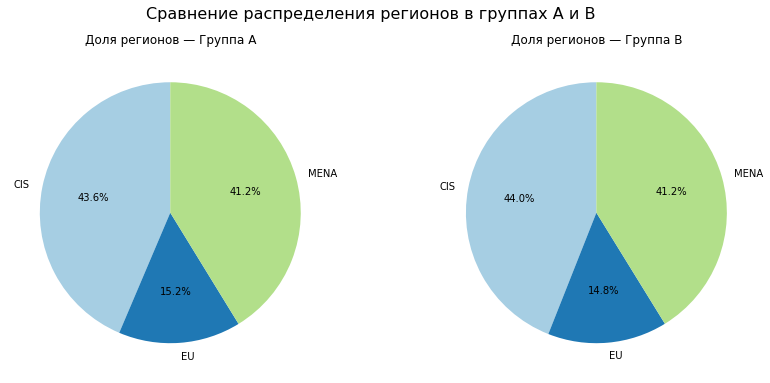

In [12]:

region_dist_A = group_A.groupby("region")["user_id"].nunique()
region_dist_B = group_B.groupby("region")["user_id"].nunique()

region_share_A = region_dist_A / region_dist_A.sum()
region_share_B = region_dist_B / region_dist_B.sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(
    region_share_A,
    labels=region_share_A.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors
)
axes[0].set_title("Доля регионов — Группа A")
axes[1].pie(
    region_share_B,
    labels=region_share_B.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors
)
axes[1].set_title("Доля регионов — Группа B")

plt.suptitle("Сравнение распределения регионов в группах A и B", fontsize=16)
plt.show()


#### Вывод после проверки A/B-теста

Выводы по первому дню A/B теста:
    1. По количеству пользователей группы практически не отличаются(разница менее 1 %)
    2. Пересечения пользователей нет
    3. Распределение пользователей по устройствам в группах без существенных отклонений
    4. Доли регионов в каждой группе представлены без существенных отклонений
    По итогам первого дня тестирование проходит без нарушений.

###  Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

####  Получение результатов теста и подсчёт основной метрики

- Считаем и сохраняем в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [13]:
sessions_test = pd.read_csv("/datasets/sessions_project_test.csv")

sessions_test["good_session"] = (sessions_test["page_counter"] >= 4).astype(int)

display(sessions_test.head())

sessions_test["session_date"] = pd.to_datetime(sessions_test["session_date"])

test_duration_days = (sessions_test["session_date"].max() - sessions_test["session_date"].min()).days + 1
print(f"Длительность теста: {test_duration_days} дней")

total_sessions = sessions_test.shape[0]

unique_users = sessions_test["user_id"].nunique()

print(f"Общее количество сессий в 2 группах: {total_sessions}")
print(f"Количество уникальных пользователей в 2 группах: {unique_users}")

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


Длительность теста: 20 дней
Общее количество сессий в 2 группах: 100005
Количество уникальных пользователей в 2 группах: 30579


####  Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведим на экран полученное значение p-value и интерпретируем его.

p-value очень большое, различия между группами практически отсутствуют

In [14]:
from scipy import stats
daily_sessions = (
    sessions_test.groupby(["session_date", "test_group"])["session_id"]
    .nunique()
    .reset_index(name="unique_sessions")
)
sessions_A = daily_sessions[daily_sessions["test_group"] == "A"]["unique_sessions"]
sessions_B = daily_sessions[daily_sessions["test_group"] == "B"]["unique_sessions"]

t_stat, p_value = stats.ttest_ind(sessions_A, sessions_B, equal_var=False)

print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Различие между группами статистически значимое — группы могут быть несопоставимыми.")
else:
    print("Различие между группами не является статистически значимым — группы сопоставимы.")

p-value: 0.9382
Различие между группами не является статистически значимым — группы сопоставимы.


####  Сравнение доли успешных сессий

Используем созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразим на экране.

In [15]:
success_rate = sessions_test.groupby("test_group")["good_session"].mean().reset_index()
success_rate.rename(columns={"good_session": "success_share"}, inplace=True)

share_A = success_rate[success_rate["test_group"] == "A"]["success_share"].values[0]
share_B = success_rate[success_rate["test_group"] == "B"]["success_share"].values[0]

diff = share_B - share_A

print(f"Доля успешных сессий в группе A: {share_A:.4f}")
print(f"Доля успешных сессий в группе B: {share_B:.4f}")
print(f"Разница долей успешных сессий (B - A): {diff:.4f}")

Доля успешных сессий в группе A: 0.3077
Доля успешных сессий в группе B: 0.3183
Разница долей успешных сессий (B - A): 0.0106


Группа B показывает небольшое улучшение доли успешных сессий по сравнению с контрольной группой A.

На первый взгляд улучшение есть, но пока неизвестно, статистически значимо ли оно.

Для окончательного вывода нужно провести A/B-тест на статистическую значимость

####  Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведим на экран полученное значение p-value и свои выводы о статистической значимости.

In [16]:
from statsmodels.stats.proportion import proportions_ztest

success_counts = sessions_test.groupby("test_group")["good_session"].sum().values
total_counts = sessions_test.groupby("test_group")["good_session"].count().values

z_stat, p_value = proportions_ztest(success_counts, total_counts)

print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Изменение доли успешных сессий статистически значимо.")
else:
    print("Изменение доли успешных сессий не является статистически значимым.")

p-value: 0.0003
Изменение доли успешных сессий статистически значимо.


####  Вывод по результатам A/B-эксперимента

Был проведен A/B тест на 41040 пользователях в течение 20 дней.
Ключевая метрика для проверки - кол-во успешных сессий(просмотр более 4 страниц за сессию)
Около 50 тысяч сессий в каждой группе, но в пересчете на уникальных пользователей это составляет примерно 15 тысяч для каждой группы.
По итогу тестирования p-value: 0.0003. Уровень значимости в эксперименте был выбран на уровне 0.05. Результат достигнут.
Внедрение нового алгоритма повляияло на рост ключевой метрики.
Рекомендовано внедрить новый алгоритм в приложение.